In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import plotly.graph_objects as go
import pandas as pd

In [294]:
a, b = 1, 2
r, h, D, P = 1, 1, 1, 0.1

N, M, T = 50, 100, 0.05
dx, dy, dt = a / N, b / M, 0.005

xx = np.linspace(0, a, N + 1)
yy = np.linspace(0, b, M + 1)

print('x interval: {} \ny interval: {} \nt interval: {}'.\
      format(dx, dy, dt))

x interval: 0.02 
y interval: 0.02 
t interval: 0.005


In [295]:
0.05/0.005

10.0

In [296]:
w = np.zeros((N+3, M+3))
v = np.zeros((N+3, M+3))

w.shape, v.shape

((53, 103), (53, 103))

In [297]:
alpha, beta = 0.25, 0.5
print('x distance: {} \ny distance: {}'.\
      format(alpha, beta))

x distance: 0.25 
y distance: 0.5


In [298]:
aa = np.logical_or(xx == xx[xx <= alpha][-1], xx == xx[xx >= alpha][0])
bb = np.logical_or(yy == yy[yy <= beta][-1], yy == yy[yy >= beta][0])
aa

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [299]:
bb

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [300]:
amask, bmask = np.meshgrid(aa, bb)
powermask = np.zeros((N+3, M+3)).astype(bool)
powermask[1:-1, 1:-1] = np.logical_and(amask, bmask).T

In [301]:
power = np.zeros((N+3, M+3))
power[powermask] = P / (dx * dy)

In [302]:
coord = np.zeros((N+3, M+3))
index = lambda n, m: (n + 1) + (m + 1)*(N + 3)

In [303]:
for i in range(N + 3):
    for j in range(M + 3):
        coord[i, j] = index(i-1, j-1)

In [304]:
reindex = lambda i: (i % (N + 3) - 1, i // (N + 3) - 1)

In [305]:
a1 = 2 * (2 / (dx**2 * dy**2) + r * h / (D * dt ** 2)) +3 * (1 / dx ** 4 + 1 / dy ** 4)
a2 = 2 * (2 / (dx**2 * dy**2) - r * h / (D * dt ** 2)) +3 * (1 / dx ** 4 + 1 / dy ** 4)

In [306]:
b1 = 1 / (2 * dx ** 4)
b4 = 1 / (2 * dy ** 4)
b3 = 1 / (dx**2 * dy ** 2)
b2 = 2 / dx ** 4 + 2 / (dx ** 2 * dy ** 2)
b5 = 2 / dy ** 4 + 2 / (dx ** 2 * dy ** 2)

In [307]:
def wmatrix(i, j):
    
    xexpr = np.zeros(((N + 3) * (M + 3)))
    
    xexpr[index(i+2, j)] = b1
    xexpr[index(i-2, j)] = b1
            
    xexpr[index(i+1, j)] = -b2
    xexpr[index(i-1, j)] = -b2
            
    for n, m in [(i+1, j+1), (i+1, j-1), (i-1, j+1), (i-1, j-1)]:
        xexpr[index(n, m)] = b3
            
    xexpr[index(i, j+2)] = b4
    xexpr[index(i, j-2)] = b4
            
    xexpr[index(i, j+1)] = -b5
    xexpr[index(i, j-1)] = -b5
    
    return xexpr

In [308]:
def dpoints(pw, pv, power):
    
    bexpr = np.zeros(((N-1)*(M-1)))
    xexpr = np.zeros(((N-1)*(M-1), (N + 3) * (M + 3)))
    
    wconst = lambda n, m: b1 * (pw[n+2, m] + pw[n-2,m]) -\
                    b2 * (pw[n+1, m] + pw[n-1,m]) +\
                    b3 * (pw[n+1, m+1] + pw[n+1, m-1] + pw[n-1, m+1] + pw[n-1, m-1]) +\
                    b4 * (pw[n, m+2] + pw[n, m-2]) -\
                    b5 * (pw[n, m+1] + w[n,m-1])
    
    
    
    for ind1, i in enumerate(range(1, N)):
        for ind2, j in enumerate(range(1, M)):
            
            xexpr[(M-1)*ind1 + ind2, :] = wmatrix(i, j)
            xexpr[(M-1)*ind1 + ind2, index(i, j)] = a1
            
            bexpr[(M-1)*ind1 + ind2] -= (wconst(i, j) + a2 * pw[i, j])
            bexpr[(M-1)*ind1 + ind2] += 2 * r * h / (D * dt) * pv[i, j] + power[i, j] / D
            
             
    return xexpr, bexpr.reshape((N-1)*(M-1), -1)

In [309]:
axd, bd = dpoints(w, v, power)
axd.shape, bd.shape

((4851, 5459), (4851, 1))

In [310]:
def cpoints(N, M):
    
    xexpr = np.zeros((4 * (N - 1), (N + 3) * (M + 3)))
    for ind1, j in enumerate([0, M]):
        for ind2, i in enumerate(range(1, N)):
            qindex = 2*(N-1) * ind1 + 2 * ind2
            #print((i, j, index(i, j)), qindex, qindex + 1)
            
            # г.у 3.21 (1)
            #print(qindex, (i, j, index(i, j)))
            xexpr[qindex, index(i, j)] = 1
            
            # г.у 3.21 (2)
            #print(qindex + 1, (i, j, index(i, j-1)), 
            #                  (i, j, index(i, j+1)))
            
#             xexpr[qindex + 1, index(i, j-1)] = 1 / (2 * dy)
#             xexpr[qindex + 1, index(i, j+1)] = 1 / (2 * dy)
            xexpr[qindex+1, index(i,j-1)] = 1 / dy ** 2
            xexpr[qindex+1, index(i, j)] = -2 / dy ** 2
            xexpr[qindex+1, index(i,j+1)] = 1 / dy ** 2
            
            
    #print()
    yexpr = np.zeros((4 * (M - 1), (N + 3) * (M + 3)))
    for ind1, i in enumerate([0, N]):
        for ind2, j in enumerate(range(1, M)):
            qindex = 2*(M-1) * ind1 + 2*ind2
            #print((i, j, index(i, j)), qindex, qindex + 1)
      
            # г.у 3.20 (1)
            #print(qindex, (i, j, index(i, j)))
            yexpr[qindex, index(i, j)] = 1 
            
            # г.у 3.20 (2)
            #print(qindex+1, (i, j, index(i-1, j)), (i, j, index(i+1, j)))
            yexpr[qindex+1, index(i+1,j)] = 1 / dx ** 2
            yexpr[qindex+1, index(i, j)] = -2 / dx ** 2
            yexpr[qindex+1, index(i-1,j)] = 1 / dx ** 2
            
    
    return np.vstack((xexpr, yexpr)), np.zeros(4*(N - 1) + 4*(M - 1)).reshape(4*(N - 1) + 4*(M - 1), -1)

In [311]:
axc, bc = cpoints(N, M)
axc.shape, bc.shape

((592, 5459), (592, 1))

In [312]:
axc, bc = cpoints(N, M)
axc.shape, bc.shape

((592, 5459), (592, 1))

In [313]:
#axc[15].reshape(M+3, -1).T

In [314]:
def bpoints(N, M):
    
    expr = np.zeros((12, (N + 3) * (M + 3)))
    for ind, (i, j) in enumerate([(0, 0), (0, M), 
                 (N, 0), (N,M)]):
        
        #print(3 * ind, i, j, index(i, j))
        expr[3 * ind, index(i, j)] = 1
        
        # г.у. (3.18)

        #print(3 * ind + 1, index(i, j-1), index(i, j+1))
#         expr[3 * ind + 1, index(i, j-1)] = 1 / (2 * dy)
#         expr[3 * ind + 1, index(i, j+1)] = 1 / (2 * dy)
        expr[3 * ind + 1, index(i, j-1)] = 1 / dy ** 2
        expr[3 * ind + 1, index(i, j) ] = -2 / dy ** 2
        expr[3 * ind + 1, index(i, j+1)] = 1 / dy ** 2
        
        # г.у. (3.19)
        #print(3 * ind + 2, index(i+1, j), index(i-1, j))
        expr[3 * ind + 2, index(i+1, j)] = 1 / dx ** 2
        expr[3 * ind + 2, index(i, j) ] = -2 / dx ** 2
        expr[3 * ind + 2, index(i-1, j)] = 1 / dx ** 2
        
    return expr, np.zeros(12).reshape(12, -1)

In [315]:
axb, bb = bpoints(N, M)
axb.shape, bb.shape

((12, 5459), (12, 1))

In [316]:
axb, bb = bpoints(N, M)
axb.shape, bb.shape

((12, 5459), (12, 1))

In [317]:
#axb[2].reshape(M + 3, -1).T

In [318]:
def apoints(N, M):
    
    expr = np.zeros((4, (N + 3) * (M + 3)))
    for ind, (i, j) in enumerate([(-1, -1 ), (-1, M+1), 
                 (N+1, -1), (N+1,M+1)]):
        
        #print(ind, i, j, index(i, j))
        expr[ind, index(i, j)] = 1
    return expr, np.zeros(4).reshape(4, -1)

In [319]:
axa, ba = apoints(N, M)
axa.shape, ba.shape

((4, 5459), (4, 1))

In [320]:
# Перевірка 1
#axa[2].reshape(M+3, -1).T

In [321]:
# Перевірка 2
for i in range(axa[0].shape[0]):
    if axa[3, i] == 1:
        print(i, reindex(i))

5458 (51, 101)


In [322]:
A = np.vstack((axa, axb, axc, axd))
B = np.vstack((ba, bb, bc, bd))

In [323]:
A.shape, B.shape

((5459, 5459), (5459, 1))

In [324]:
res = np.linalg.solve(A, B)

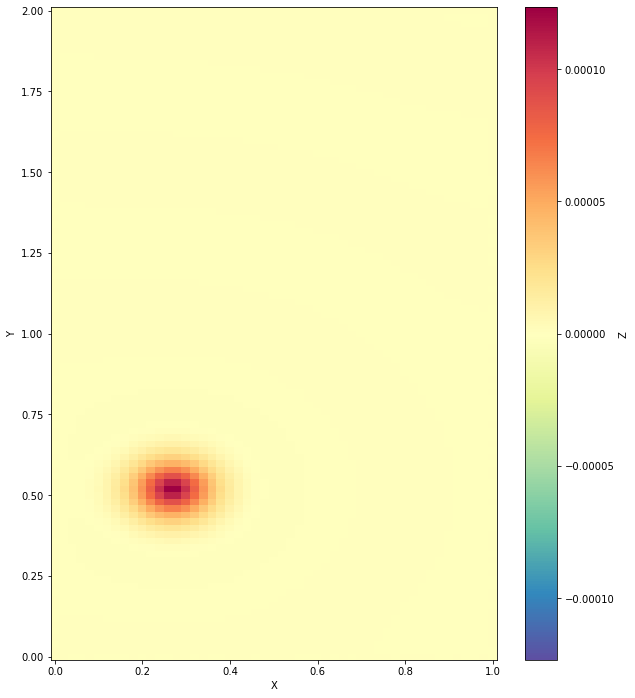

In [325]:
fig, ax = plt.subplots(1, 1, figsize=(10,12))

X, Y = np.meshgrid(xx, yy)
Z = res.reshape(M + 3, -1)[1:-1, 1:-1]

norm = matplotlib.colors.Normalize(-abs(Z).max(), abs(Z).max())
p = ax.pcolor(X, Y, Z, norm=norm, cmap=matplotlib.cm.Spectral_r, shading='auto')

ax.axis('tight')
ax.set_xlabel('X')

ax.set_ylabel('Y')
# ax.grid()
# ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(4))
# ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(4))

cb = fig.colorbar(p, ax=ax)
cb.set_label('Z')

# cb.set_ticks([-1, -.5, 0, .5, 1])


In [291]:
X, Y = np.meshgrid(xx, yy)
Z = res.reshape(M + 3, -1)[1:-1, 1:-1]
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
fig.update_layout(title='Surface', autosize=False,
                  width=950, height=950,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

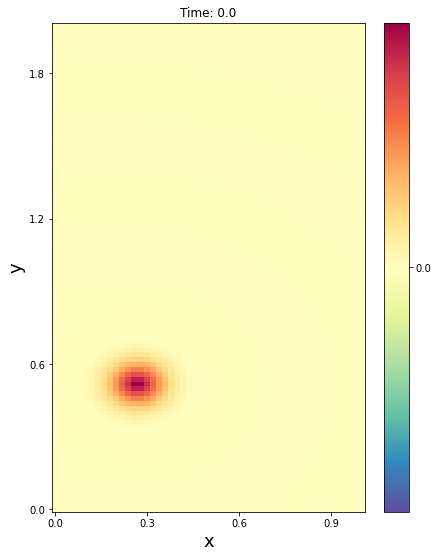

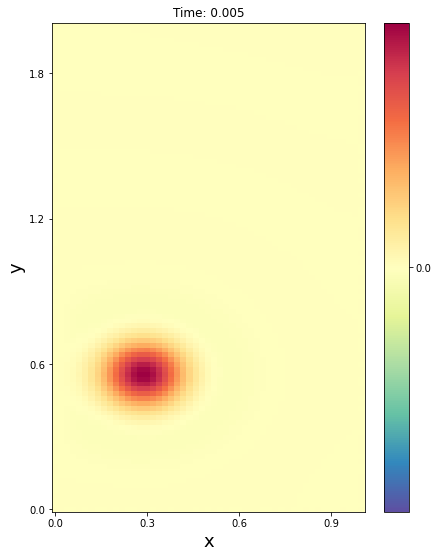

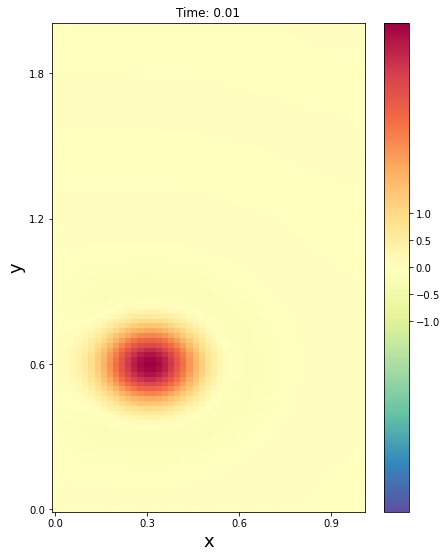

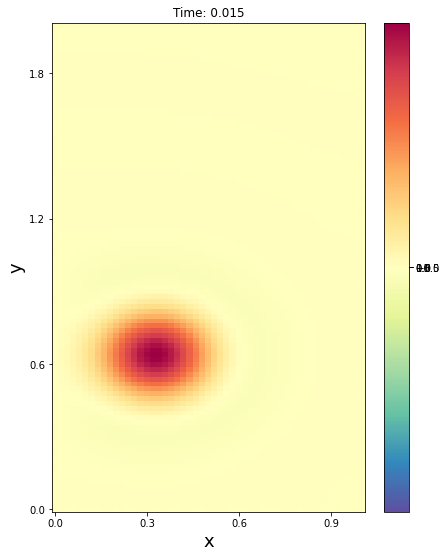

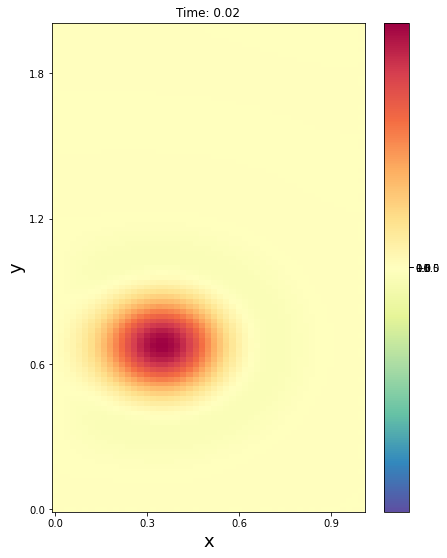

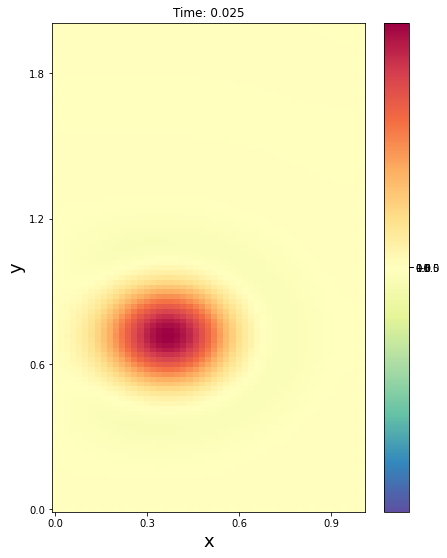

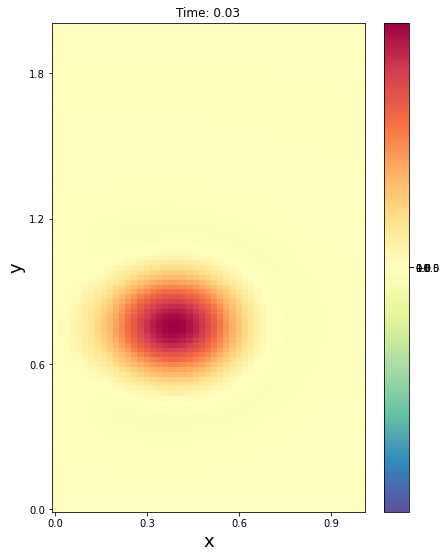

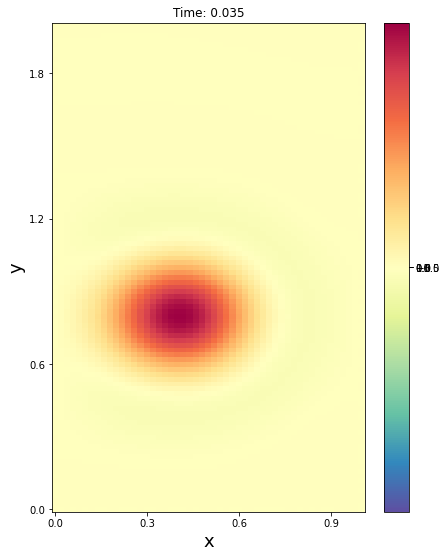

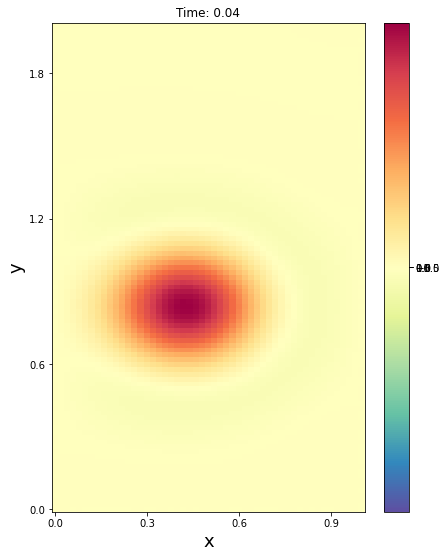

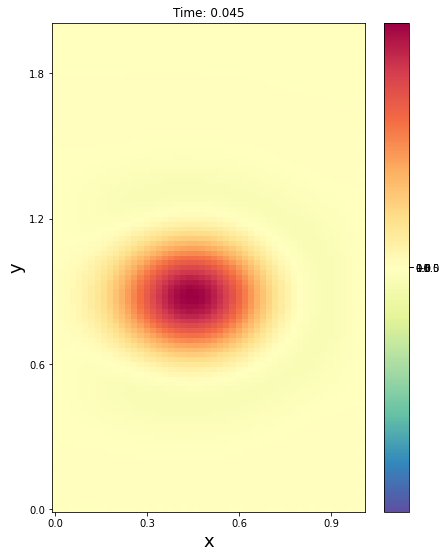

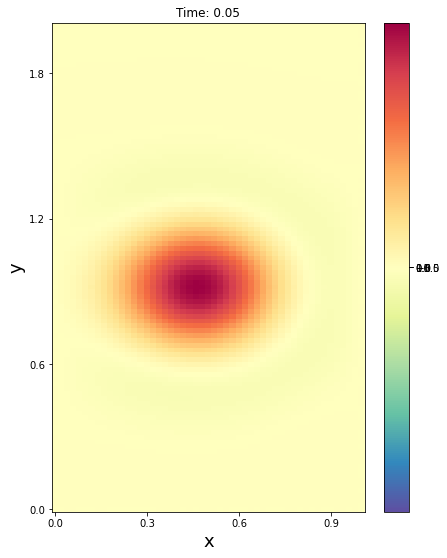

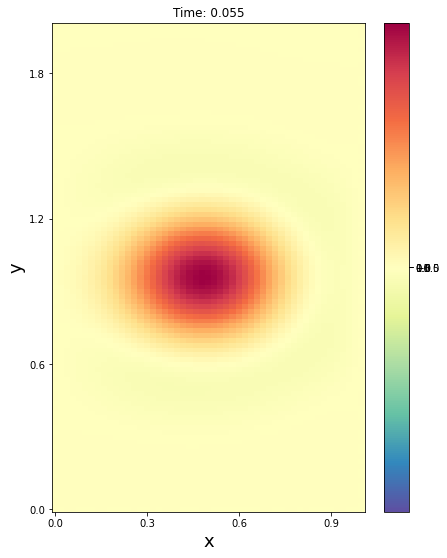

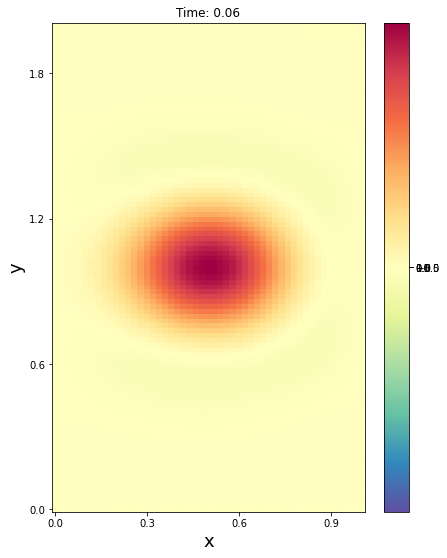

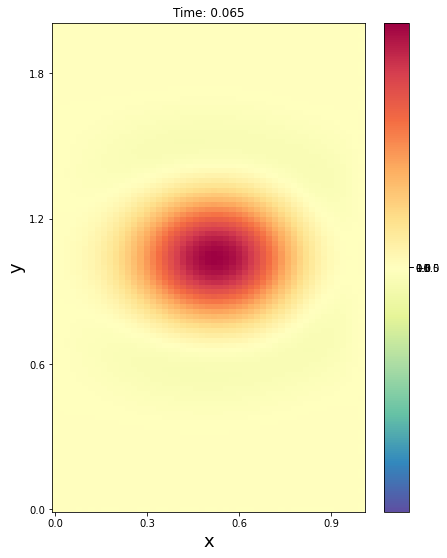

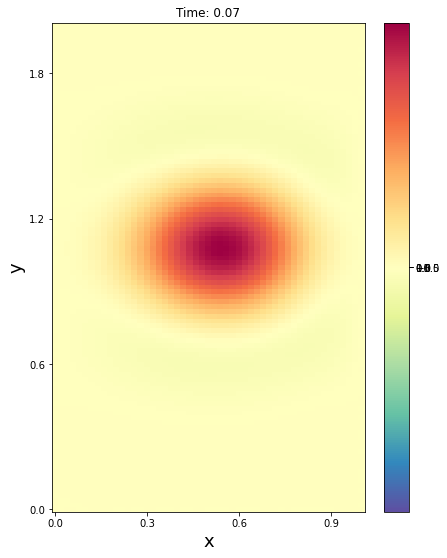

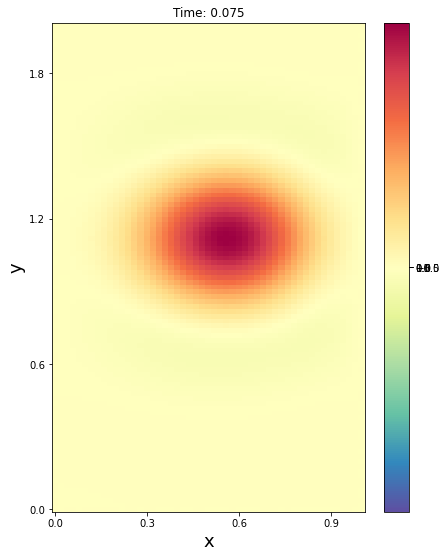

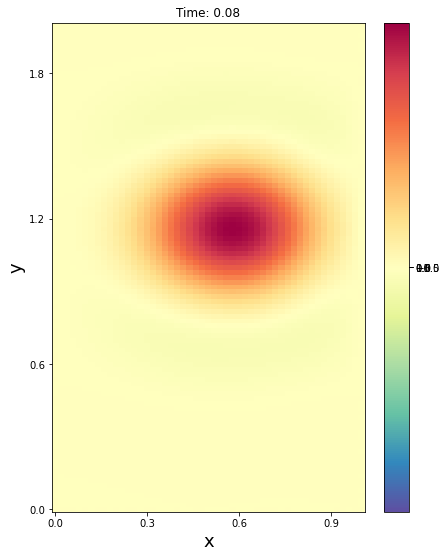

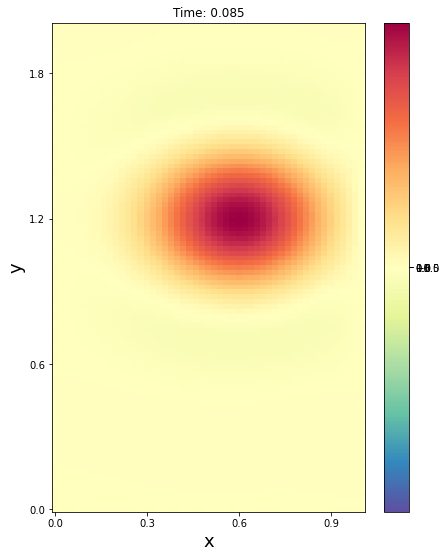

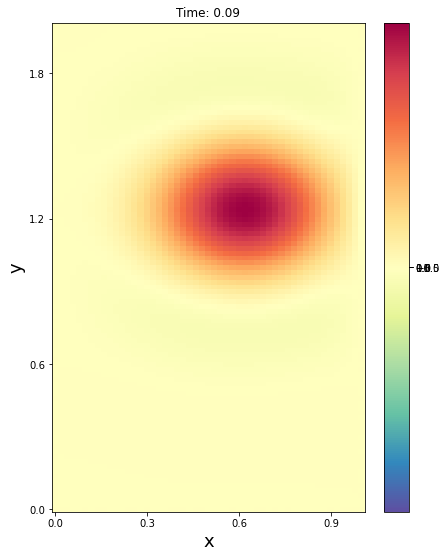

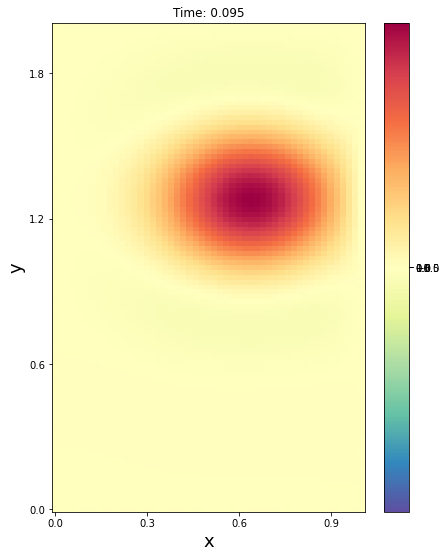

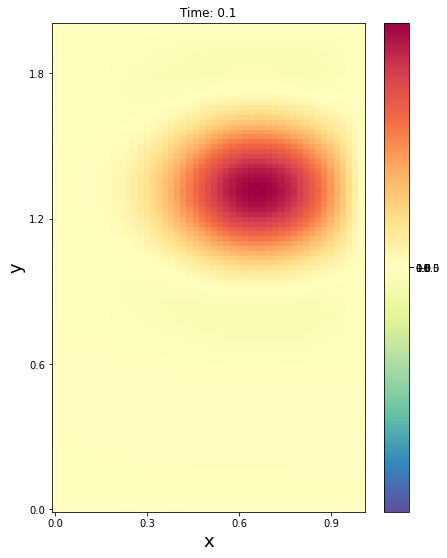

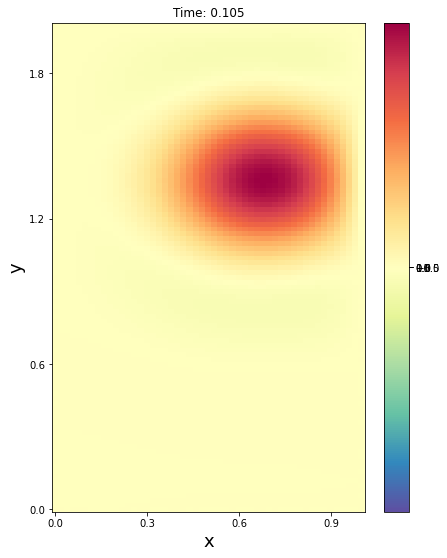

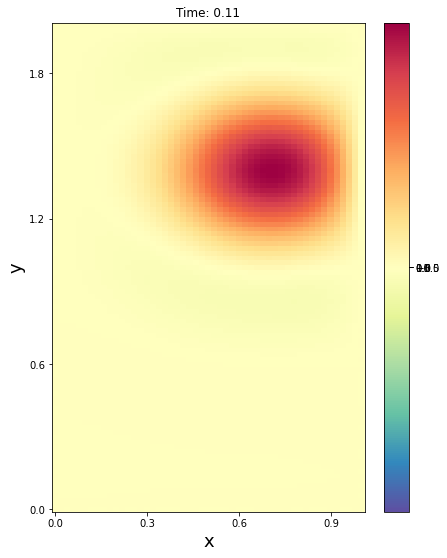

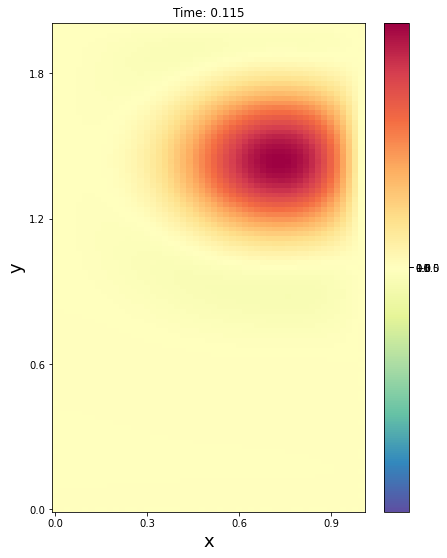

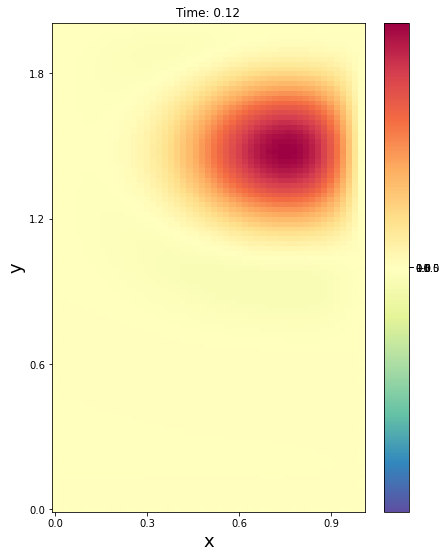

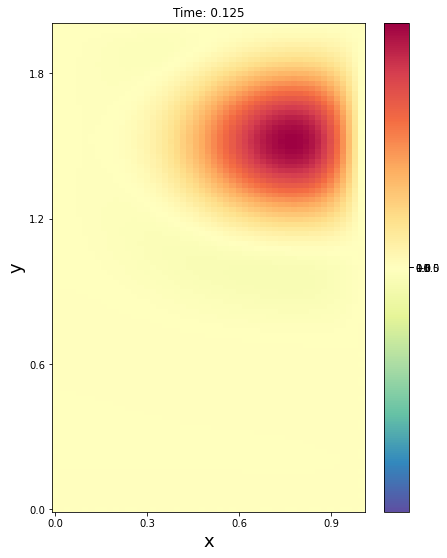

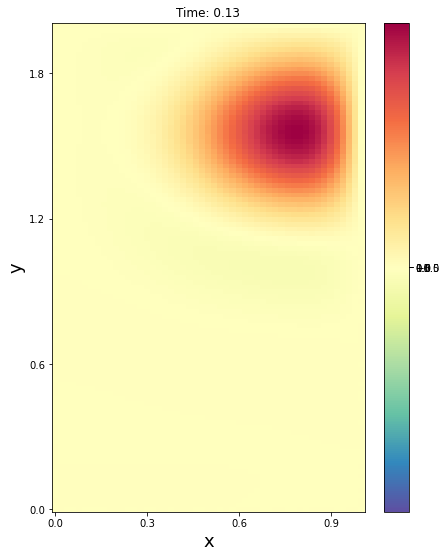

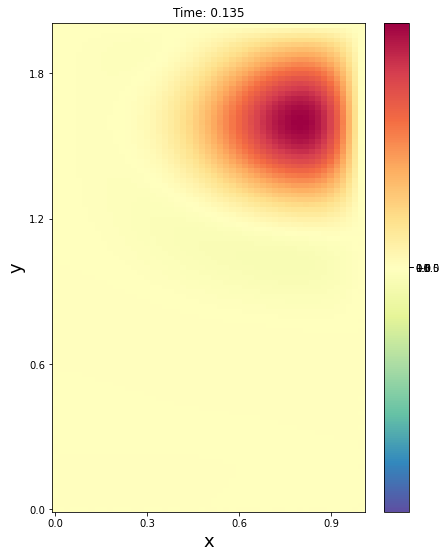

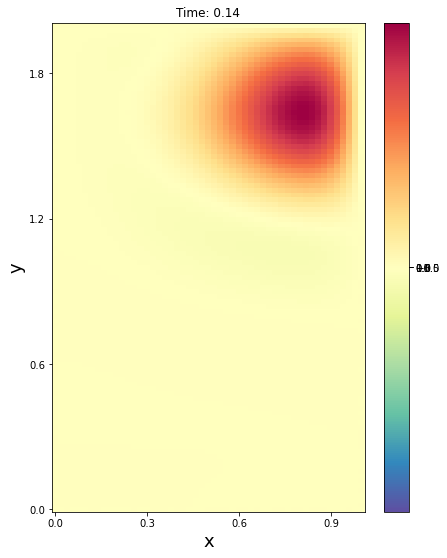

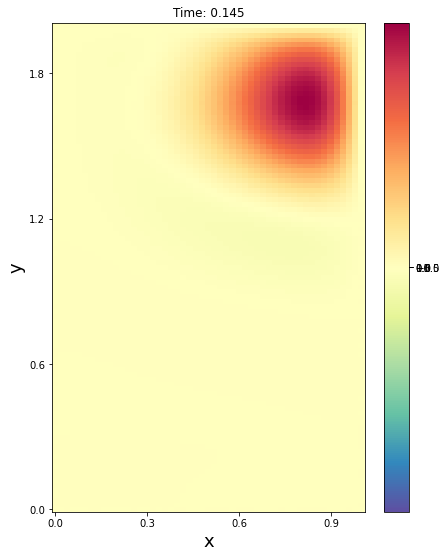

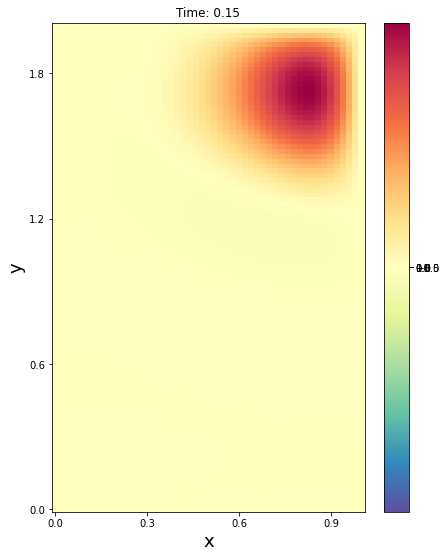

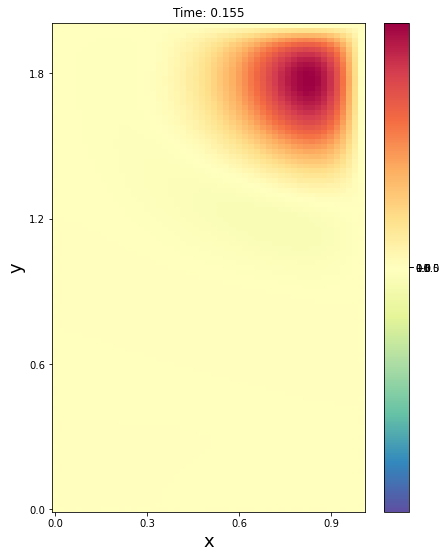

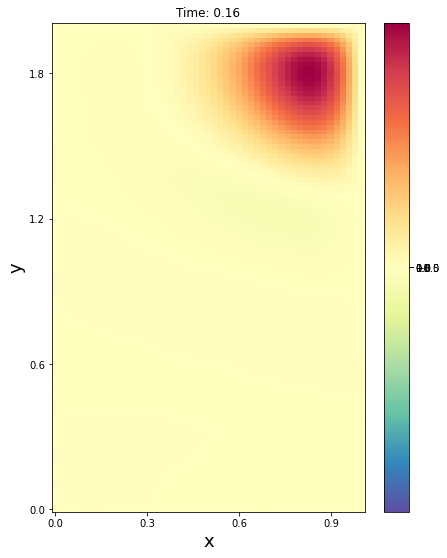

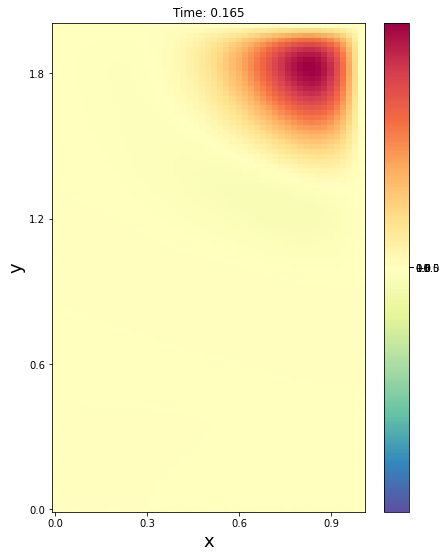

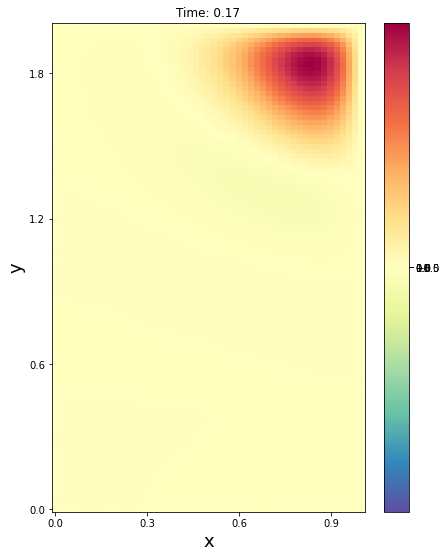

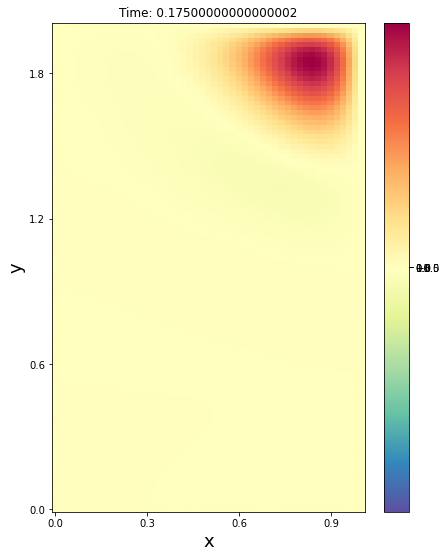

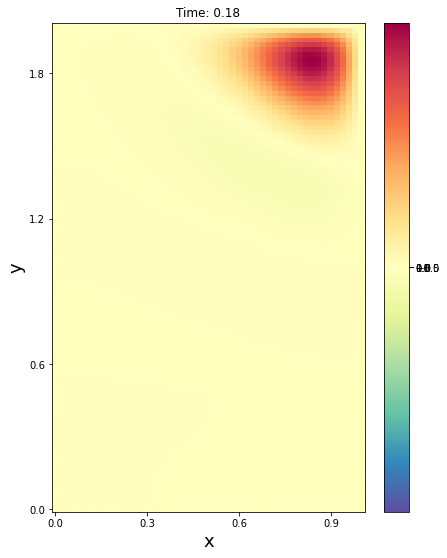

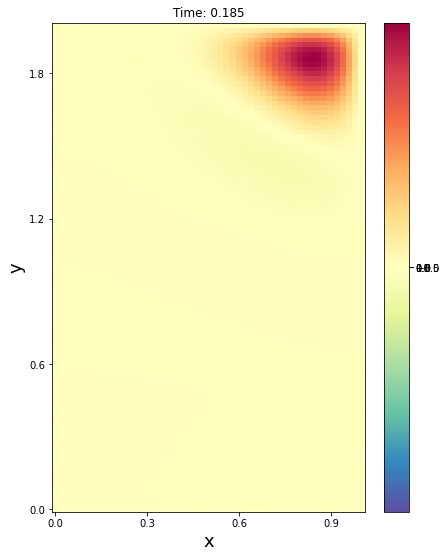

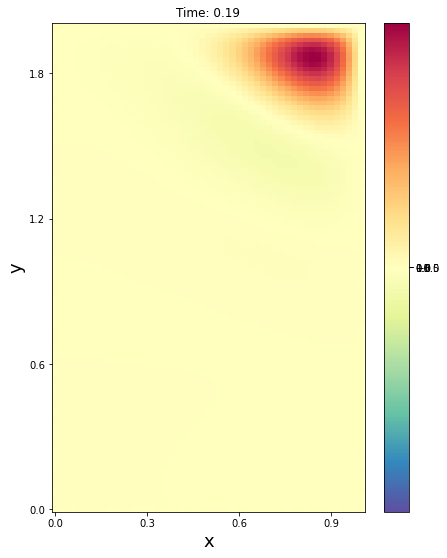

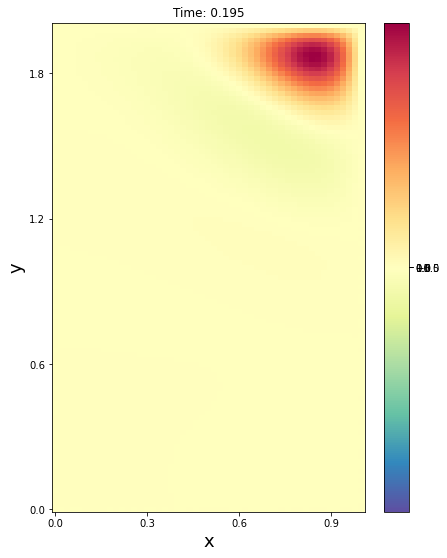

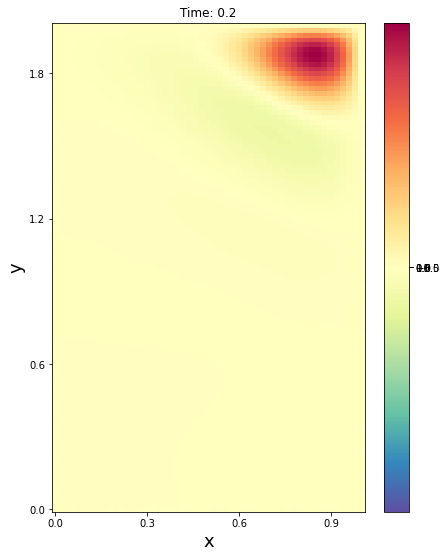

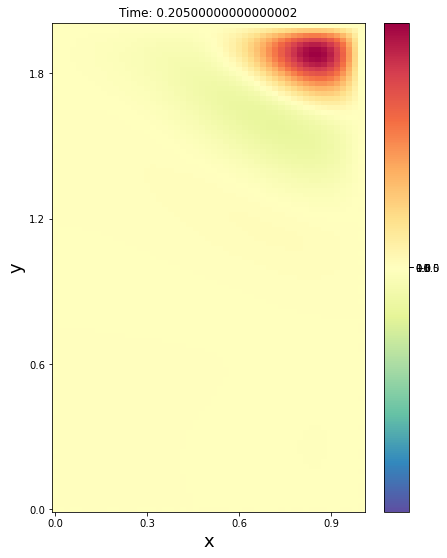

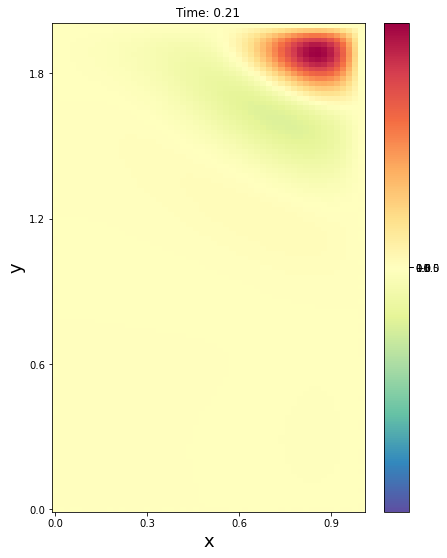

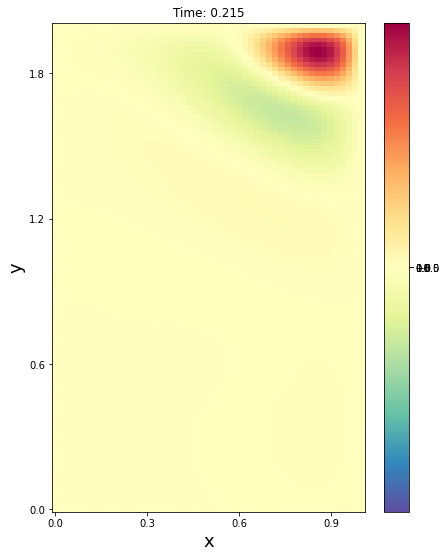

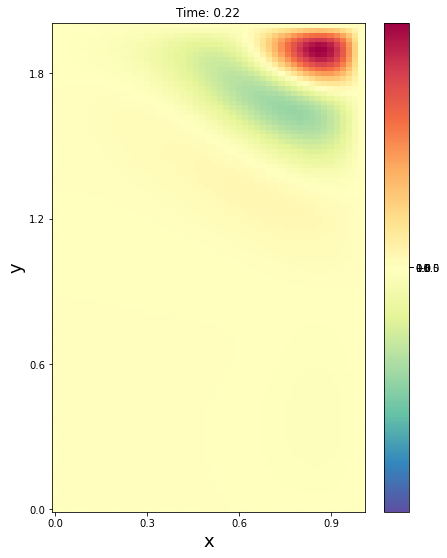

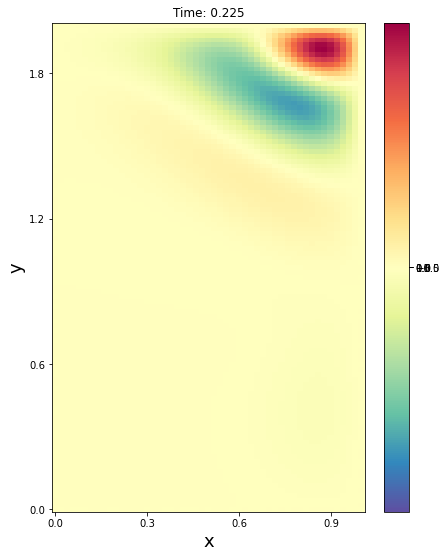

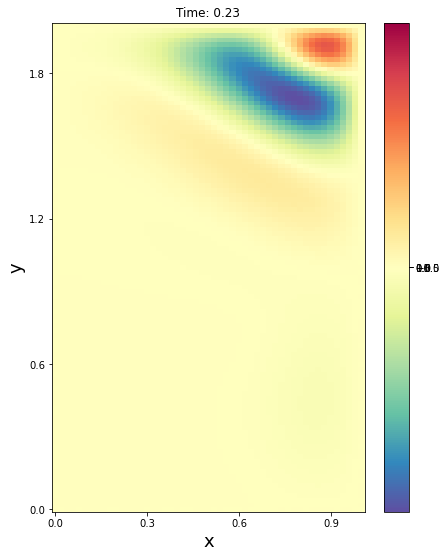

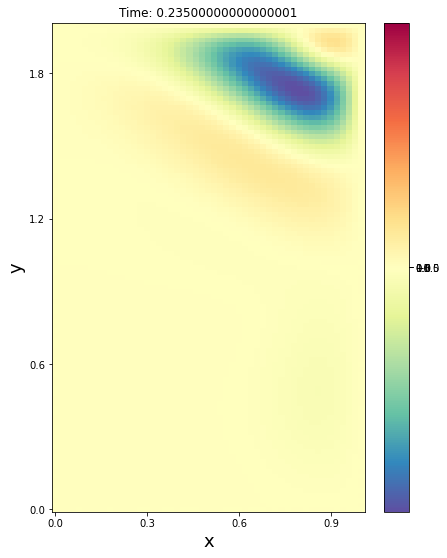

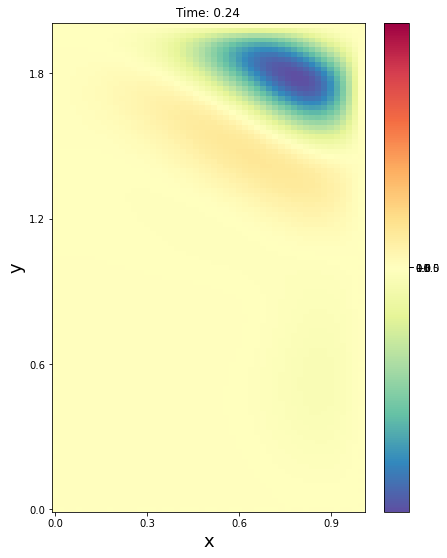

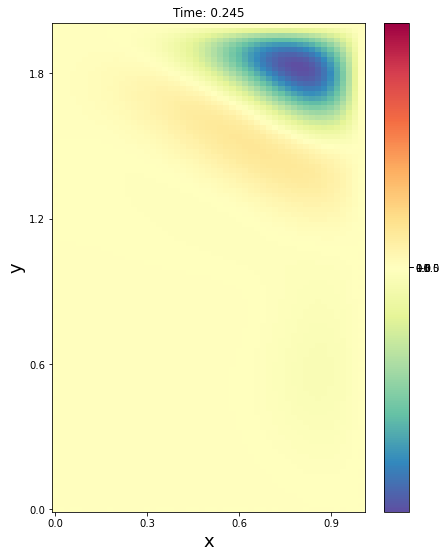

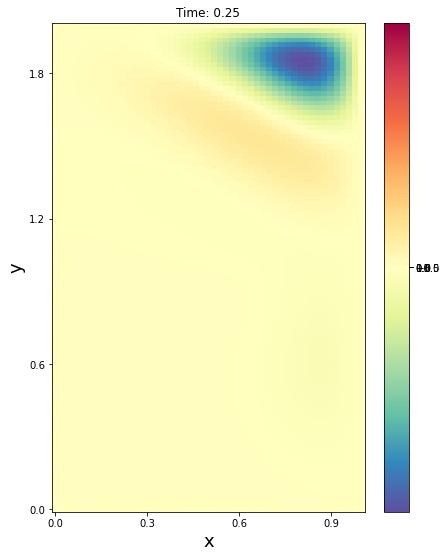

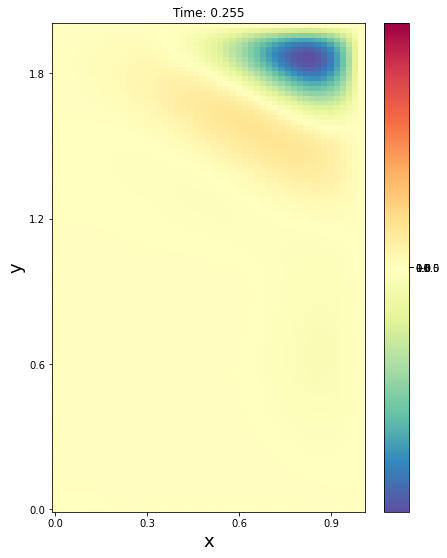

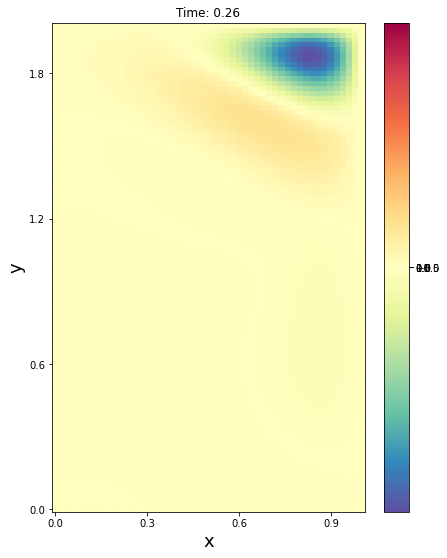

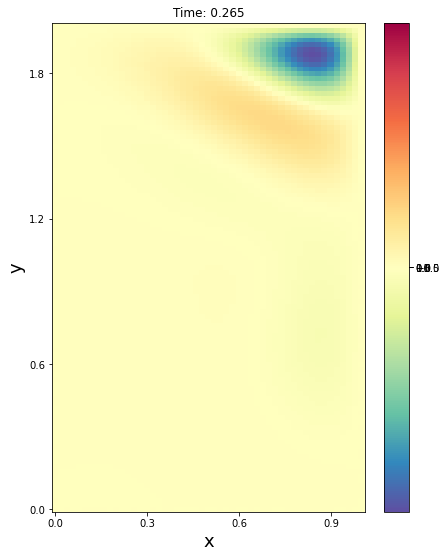

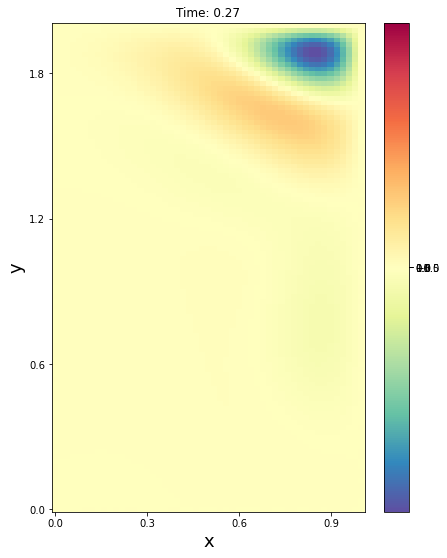

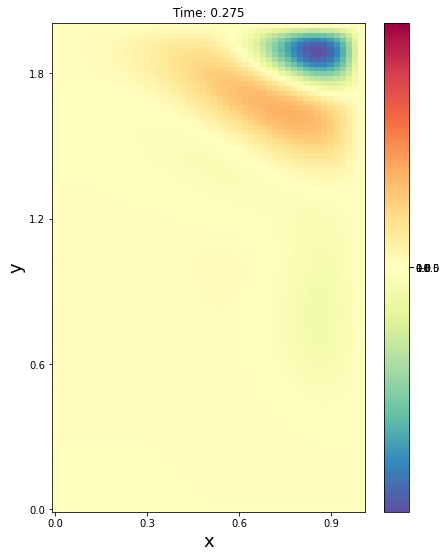

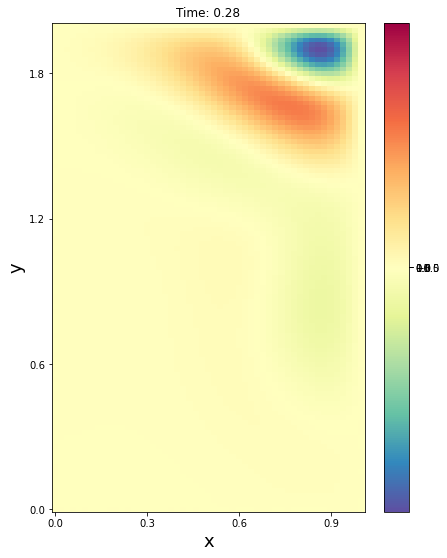

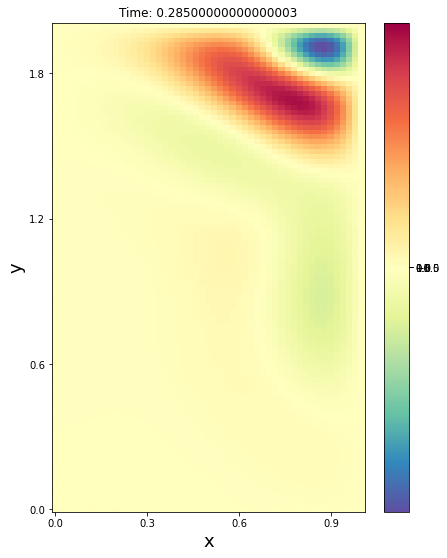

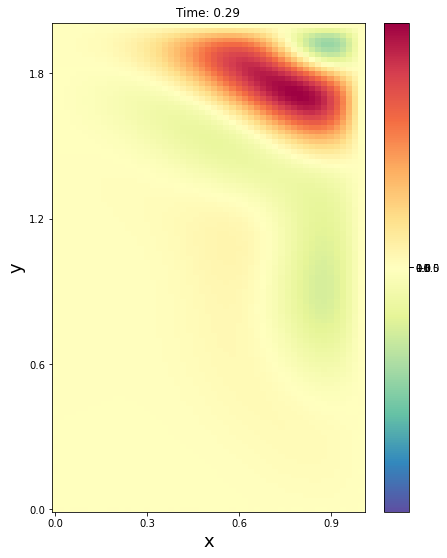

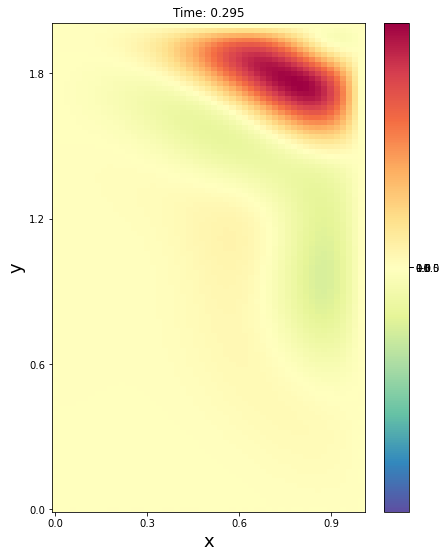

In [326]:
def update_v(ow, nw, v):
    return 2 * (nw - ow) - v

current_power = power
current_w, current_v = w, v

n_iter, data = 60, []
for i in range(n_iter):
    
    aequations, aconst = apoints(N, M)
    bequations, bconst = bpoints(N, M)
    cequations, cconst = cpoints(N, M)
    
    if i * dt > T:
        current_power = np.zeros_like(power)
        
    
    dequations, dconst = dpoints(current_w, current_v, 
                                 current_power)
    
    A = np.vstack((aequations, bequations, cequations, dequations))
    B = np.vstack((aconst, bconst, cconst, dconst))
    
    z = np.linalg.solve(A, B)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 9))

    X, Y = np.meshgrid(xx, yy)
    Z = z.reshape(M + 3, -1)[1:-1, 1:-1]
    
    if i%2 != 0:
        Z= -Z

    norm = matplotlib.colors.Normalize(-abs(Z).max(), abs(Z).max())
    p = ax.pcolor(X, Y, Z, norm=norm, cmap=matplotlib.cm.Spectral_r, shading='auto')

    ax.axis('tight')
    ax.set_title('Time: {}'.format(i * dt))
    ax.set_xlabel(r"x", fontsize=18)
    ax.set_ylabel(r"y", fontsize=18)
    
    ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(4))
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(4))

    cb = fig.colorbar(p, ax=ax)
    cb.set_ticks([-1, -.5, 0, .5, 1])
    plt.show()
    
    
#     fig, ax = plt.subplots(1, 1, figsize=(16, 12), 
#                          subplot_kw={'projection': '3d'})

#     def title_and_labels(ax, title):
#         ax.set_title(title)
#         ax.set_xlabel("$x$", fontsize=16)
#         ax.set_ylabel("$y$", fontsize=16)


#     p = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
#                         linewidth=0, antialiased=False, norm=norm, cmap=mpl.cm.Blues)


#     cb = fig.colorbar(p, ax=ax, shrink=0.6)
#     title_and_labels(ax, "plot_surface")
    
    
    
    current_v = update_v(current_w, z.reshape(M + 3, -1).T, current_v)
    current_w = z.reshape(M + 3, -1).T
    
    data.append(current_w)

In [327]:
# fig, ax = plt.subplots(1, 1, figsize=(16, 12), 
#                          subplot_kw={'projection': '3d'})

# def title_and_labels(ax, title):
#     ax.set_title(title)
#     ax.set_xlabel("$x$", fontsize=16)
#     ax.set_ylabel("$y$", fontsize=16)
#     ax.set_zlabel("$z$", fontsize=16)
    
# X, Y = np.meshgrid(xx, yy)
# Z = res.reshape(M + 3, -1)[1:-1, 1:-1]

# norm = matplotlib.colors.Normalize(-abs(Z).max(), abs(Z).max())
# p = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
#                     linewidth=0, antialiased=False, norm=norm, cmap=matplotlib.cm.Blues)


# cb = fig.colorbar(p, ax=ax, shrink=0.6)
# title_and_labels(ax, "plot_surface")